# UK Price Paid Data 2020

Plot mean house prices by county (England and Wales) on UK map.

See https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads for source data.

In [914]:
# Import libaries
import numpy as np # import numpy
import pandas as pd # import pandas
import geopandas as gpd # import geopandas
import matplotlib.pyplot as plt
#import matplotlib.cm
import sys

Let's load the source data into a pandas dataframe so that we can have a look at it. The raw data doesn't have column headings so we'll add some.

In [915]:
# Read Price Paid Transaction Data for 2020
# https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads 
pptd = pd.read_csv('./data/pp-2020.csv', \
                   header=None, \
                   names=["Transaction_ID","Price","Date_of_Transfer","Postcode","Property_Type","Old_New", \
                          "Duration","PAON","SAON","Street","Locality","Town_City","District","County", \
                          "PPD_Category_Type","Record_Status"])

This is a summary of what each column represents:

|   #  | Data item | Explanation (where appropriate) | 
| --- |:--------- |:------------------------------- | 
| 0 | Transaction unique identifier | A reference number which is generated automatically recording each published sale. |
| -  |            -                   | The number is unique and will change each time a sale is recorded. |
| 1 | Price | Sale price stated on the transfer deed. |
| 2 | Date of Transfer | Date when the sale was completed, as stated on the transfer deed. |
| 3 | Postcode | This is the postcode used at the time of the original transaction. |
| -  | -  | Note that postcodes can be reallocated and these changes are not reflected in the Price Paid Dataset. |
| 4 | Property Type | D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other |
|  - | -  | Note that: |
|  - | -  | - we only record the above categories to describe property type, we do not separately identify bungalows. |
| -  | -  | - end-of-terrace properties are included in the Terraced category above. |
| -  | -  | - ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values. |
| 5 | Old/New | Indicates the age of the property and applies to all price paid transactions, |
| -  |  - | residential and non-residential. |
| -  | -  | Y = a newly built property, N = an established residential building |
| 6 | Duration | Relates to the tenure: F = Freehold, L= Leasehold etc. |
|  - |  -  | Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset. |
| 7 | PAON | Primary Addressable Object Name. Typically the house number or name. |
| 8 | SAON | Secondary Addressable Object Name. Where a property has been divided into separate |
|  - | -  | units (for example, flats), the PAON (above) will identify the building and a SAON will |
|  - | -  | be specified that identifies the separate unit/flat.  |
| 9 | Street | -  |
| 10 | Locality |  - |
| 11 | Town/City | -  |
| 12 | District |  - |
| 13 | County | -  |
| 14 | PPD Category Type | Indicates the type of Price Paid transaction. |
|  -  |  - | A = Standard Price Paid entry, includes single residential property sold for value. |
|   - | -  | B = Additional Price Paid entry including transfers under a power of sale/repossessions, |
|  -  |  - | buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals. |
|   - |  - | Note that category B does not separately identify the transaction types stated. |
|  -  |  - | HM Land Registry has been collecting information on Category A transactions from |
|   - | -  | January 1995. Category B transactions were identified from October 2013. |
| 15 | Record Status - monthly file only | Indicates additions, changes and deletions to the records.(see guide below). |
|  -  |  - | A = Addition |
|   - | -  | C = Change |
|   - | -  | D = Delete. |
| -   |  - | Note that where a transaction changes category type due to misallocation (as above) |
|  -  |  - | it will be deleted from the original category type and added to the correct category with |
| -   | -  | a new transaction unique identifier. |


In [916]:
pptd.shape

(377340, 16)

In [917]:
len(pptd.Postcode.unique())

283541

In [918]:
len(pptd.County.unique())

111

We have about 380,000 data points and each point has 16 variables (as per the column names above). There are about 280,000 unique postcodes and 111 county names.

In [919]:
pptd.head()

,Transaction_ID,Price,Date_of_Transfer,Postcode,Property_Type,Old_New,Duration,PAON,SAON,Street,Locality,Town_City,District,County,PPD_Category_Type,Record_Status
0,{9DBAD222-1032-6EB3-E053-6B04A8C0F257},138000,2020-01-17 00:00,DN22 0AU,D,N,F,3,NaN,ST MARTINS ROAD,NORTH LEVERTON,RETFORD,BASSETLAW,NOTTINGHAMSHIRE,B,A
1,{9DBAD222-103A-6EB3-E053-6B04A8C0F257},72000,2020-01-17 00:00,NG17 3HD,T,N,F,79,NaN,INSTITUTE STREET,STANTON HILL,SUTTON-IN-ASHFIELD,ASHFIELD,NOTTINGHAMSHIRE,A,A
2,{9DBAD222-103B-6EB3-E053-6B04A8C0F257},207500,2020-01-03 00:00,NG18 3NY,D,N,F,34,NaN,WYNNDALE DRIVE,NaN,MANSFIELD,MANSFIELD,NOTTINGHAMSHIRE,A,A
3,{9DBAD222-103F-6EB3-E053-6B04A8C0F257},320000,2020-01-10 00:00,NG13 9PW,S,N,F,HALL FARM COTTAGE,1,CHAPEL LANE,GRANBY,NOTTINGHAM,RUSHCLIFFE,NOTTINGHAMSHIRE,A,A
4,{9DBAD222-1043-6EB3-E053-6B04A8C0F257},137000,2020-01-03 00:00,NG4 2DP,D,N,F,46,NaN,COLWICK MANOR FARM,COLWICK,NOTTINGHAM,GEDLING,NOTTINGHAMSHIRE,A,A


Let's see what the counties look like. Notice that we have areas like 'Greater London' rather than individual London boroughs.

In [920]:
print(pptd.County.unique())

['NOTTINGHAMSHIRE' 'CITY OF NOTTINGHAM' 'NORTH YORKSHIRE' 'YORK'
 'GREATER MANCHESTER' 'OXFORDSHIRE' 'STAFFORDSHIRE' 'STOKE-ON-TRENT'
 'WEST MIDLANDS' 'SUFFOLK' 'ISLE OF WIGHT' 'GREATER LONDON' 'KENT'
 'MEDWAY' 'NORFOLK' 'MILTON KEYNES' 'BUCKINGHAMSHIRE'
 'CITY OF PETERBOROUGH' 'CAMBRIDGESHIRE' 'WOKINGHAM' 'SLOUGH'
 'BRACKNELL FOREST' 'READING' 'WINDSOR AND MAIDENHEAD' 'WEST BERKSHIRE'
 'CITY OF KINGSTON UPON HULL' 'NORTH EAST LINCOLNSHIRE'
 'NORTH LINCOLNSHIRE' 'EAST RIDING OF YORKSHIRE' 'CITY OF BRISTOL' 'ESSEX'
 'SOUTHEND-ON-SEA' 'THURROCK' 'SOUTH GLOUCESTERSHIRE' 'GLOUCESTERSHIRE'
 'HERTFORDSHIRE' 'HAMPSHIRE' 'PORTSMOUTH' 'SOUTHAMPTON'
 'BOURNEMOUTH, CHRISTCHURCH AND POOLE' 'EAST SUSSEX' 'BRIGHTON AND HOVE'
 'WORCESTERSHIRE' 'WEST YORKSHIRE' 'HEREFORDSHIRE'
 'CHESHIRE WEST AND CHESTER' 'MERSEYSIDE' 'STOCKTON-ON-TEES'
 'NORTHAMPTONSHIRE' 'CHESHIRE EAST' 'WARRINGTON'
 'BATH AND NORTH EAST SOMERSET' 'NORTH SOMERSET' 'HALTON' 'GWYNEDD'
 'SWANSEA' 'PEMBROKESHIRE' 'DEVON' 'CITY OF PLYMOU

The county names look a bit rubbish so let's tidy them up a bit.

In [921]:
# Tidy up county names
pptd["County"] = pptd["County"].str.title()
pptd["County"] = pptd["County"].str.replace('-On-', '-on-', regex=True)
pptd["County"] = pptd["County"].str.replace(' Upon ', ' upon ', regex=True)
pptd["County"] = pptd["County"].str.replace(' And ', ' and ', regex=True)
pptd["County"] = pptd["County"].str.replace(' With ', ' with ', regex=True)
pptd["County"] = pptd["County"].str.replace(' Of ', ' of ', regex=True)
pptd["County"] = pptd["County"].str.replace('City of ', '', regex=True)
pptd["County"] = pptd["County"].str.replace('The Vale', 'Vale', regex=True)
pptd["County"] = pptd["County"].str.replace(' Taff', ' Taf', regex=True)

In [922]:
print(pptd.County.unique())

['Nottinghamshire' 'Nottingham' 'North Yorkshire' 'York'
 'Greater Manchester' 'Oxfordshire' 'Staffordshire' 'Stoke-on-Trent'
 'West Midlands' 'Suffolk' 'Isle of Wight' 'Greater London' 'Kent'
 'Medway' 'Norfolk' 'Milton Keynes' 'Buckinghamshire' 'Peterborough'
 'Cambridgeshire' 'Wokingham' 'Slough' 'Bracknell Forest' 'Reading'
 'Windsor and Maidenhead' 'West Berkshire' 'Kingston upon Hull'
 'North East Lincolnshire' 'North Lincolnshire' 'East Riding of Yorkshire'
 'Bristol' 'Essex' 'Southend-on-Sea' 'Thurrock' 'South Gloucestershire'
 'Gloucestershire' 'Hertfordshire' 'Hampshire' 'Portsmouth' 'Southampton'
 'Bournemouth, Christchurch and Poole' 'East Sussex' 'Brighton and Hove'
 'Worcestershire' 'West Yorkshire' 'Herefordshire'
 'Cheshire West and Chester' 'Merseyside' 'Stockton-on-Tees'
 'Northamptonshire' 'Cheshire East' 'Warrington'
 'Bath and North East Somerset' 'North Somerset' 'Halton' 'Gwynedd'
 'Swansea' 'Pembrokeshire' 'Devon' 'Plymouth' 'Torbay' 'Middlesbrough'
 'Hartlepool

That looks better. Now we'll extract just the columns we are interested in - the county name and the price paid - and rename the columns slighty (so that the county name matches the naming used in the shapefile below).

In [923]:
merge_df = pptd[['County', 'Price']]
merge_df = merge_df.rename(columns={"County": "ctyua19nm", "Price": "mean_price"})

Finally, we'll work out the mean price paid in each county, giving us a dataframe with 111 rows (indexed with the county name).

In [924]:
merge_df = merge_df.groupby(['ctyua19nm']).mean()

In [925]:
merge_df.shape

(111, 1)

In [926]:
merge_df.head()

,mean_price
ctyua19nm,
Bath and North East Somerset,426447.868178
Bedford,316414.396195
Blackburn with Darwen,146448.218223
Blackpool,130203.005172
Blaenau Gwent,110911.826879


Now we need some map data.

In [927]:
# Load the UK shapefile
# https://geoportal.statistics.gov.uk/datasets/counties-december-2019-boundaries-en-bfe
# This provides shape data for UK counties
map_df = gpd.read_file("data/Counties_and_Unitary_Authorities__December_2019__Boundaries_UK_BFE.shp")

In [928]:
map_df.shape

(216, 11)

In [929]:
map_df.head()

,objectid,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.834667e+07,66121.472650,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.455359e+07,41055.809886,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.537854e+08,105292.138896,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.097308e+08,108085.255484,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((423496.602 524724.299, 423497.204 52..."


In [930]:
print(map_df.ctyua19nm.unique())

[u'Hartlepool' u'Middlesbrough' u'Redcar and Cleveland'
 u'Stockton-on-Tees' u'Darlington' u'Halton' u'Warrington'
 u'Blackburn with Darwen' u'Blackpool' u'Kingston upon Hull, City of'
 u'East Riding of Yorkshire' u'North East Lincolnshire'
 u'North Lincolnshire' u'York' u'Derby' u'Leicester' u'Rutland'
 u'Nottingham' u'Herefordshire, County of' u'Telford and Wrekin'
 u'Stoke-on-Trent' u'Bath and North East Somerset' u'Bristol, City of'
 u'North Somerset' u'South Gloucestershire' u'Plymouth' u'Torbay'
 u'Swindon' u'Peterborough' u'Luton' u'Southend-on-Sea' u'Thurrock'
 u'Medway' u'Bracknell Forest' u'West Berkshire' u'Reading' u'Slough'
 u'Windsor and Maidenhead' u'Wokingham' u'Milton Keynes'
 u'Brighton and Hove' u'Portsmouth' u'Southampton' u'Isle of Wight'
 u'County Durham' u'Cheshire East' u'Cheshire West and Chester'
 u'Shropshire' u'Cornwall' u'Isles of Scilly' u'Wiltshire' u'Bedford'
 u'Central Bedfordshire' u'Northumberland'
 u'Bournemouth, Christchurch and Poole' u'Dorset' u'B

Notice that we have 216 counties and unitary authorities listed, including all the individual London boroughs. Looks like we need to aggregate some of these areas up into broader areas. Comparing this data with what we have above, we need to deal with Greater London, Greater Manchester, Merseyside, Shropshire, South Yorkshire, Tyne and Wear, West Midlands and West Yorkshire.

We'll start by selecting only the columns we need - the area name and the geometry for the shape.

In [931]:
map_df = map_df[['ctyua19nm', "geometry"]]

Then, for each aggregrate area, we essentially copy the smaller areas into a temporary dataframe, removing each of them from the main dataframe (map_df) as we go. Then we 'dissolve' (i.e. merge together) the sub areas into a single aggregate area and add it back onto the end of the main dataframe.

This step seems very complicated. There may well be a better way of doing this.

In [932]:
# Need to combine (and then remove) the following to replace with 'Greater London': 'City of London'
# 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden'
# 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
# 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
# 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
# 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
# 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
# 'Westminster'
london = map_df[map_df['ctyua19nm'] == 'City of London']
map_df.drop(map_df[map_df['ctyua19nm'] == 'City of London'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Barking and Dagenham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Barking and Dagenham'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Barnet'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Barnet'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Bexley'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bexley'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Brent'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Brent'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Bromley'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bromley'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Camden'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Camden'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Croydon'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Croydon'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Ealing'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Ealing'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Enfield'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Enfield'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Greenwich'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Greenwich'].index, inplace = True)
london = london.append(map_df[map_df['ctyua19nm'] == 'Hackney'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Hackney'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Hammersmith and Fulham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Hammersmith and Fulham'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Haringey'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Haringey'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Harrow'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Harrow'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Havering'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Havering'].index, inplace = True)
london = london.append(map_df[map_df['ctyua19nm'] == 'Hillingdon'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Hillingdon'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Hounslow'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Hounslow'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Islington'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Islington'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Kensington and Chelsea'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Kensington and Chelsea'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Kingston upon Thames'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Kingston upon Thames'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Lambeth'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Lambeth'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Lewisham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Lewisham'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Merton'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Merton'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Newham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Newham'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Redbridge'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Redbridge'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Richmond upon Thames'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Richmond upon Thames'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Southwark'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Southwark'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Sutton'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Sutton'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Tower Hamlets'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Tower Hamlets'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Waltham Forest'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Waltham Forest'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Wandsworth'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Wandsworth'].index, inplace = True) 
london = london.append(map_df[map_df['ctyua19nm'] == 'Westminster'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Westminster'].index, inplace = True) 
#
london = london.assign(area='Greater London')
greater_london = london.dissolve(by='area')
greater_london["ctyua19nm"] = "Greater London"
map_df = map_df.append(greater_london)

In [933]:
# Need to combine (and then remaove) the following and replace with 'Greater Manchester': 'Bolton' 'Bury'
# 'Manchester' 'Oldham' 'Rochdale' 'Salford' 'Stockport' 'Tameside'
# 'Trafford' 'Wigan'
manchester = map_df[map_df['ctyua19nm'] == 'Bolton']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bolton'].index, inplace = True)  
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Manchester'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Manchester'].index, inplace = True) 
eastyorkshire = eastyorkshire.append(map_df[map_df['ctyua19nm'] == 'Bury'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bury'].index, inplace = True)
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Oldham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Oldham'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Rochdale'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Rochdale'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Salford'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Salford'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Stockport'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Stockport'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Tameside'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Tameside'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Trafford'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Trafford'].index, inplace = True) 
manchester = manchester.append(map_df[map_df['ctyua19nm'] == 'Wigan'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Wigan'].index, inplace = True) 
#
manchester = manchester.assign(area='Greater Manchester')
greater_manchester = manchester.dissolve(by='area')
greater_manchester["ctyua19nm"] = "Greater Manchester"
map_df = map_df.append(greater_manchester)

In [934]:
# Need to combine (and then remaove) the following and replace with 'Merseyside':
merseyside = map_df[map_df['ctyua19nm'] == 'Knowsley']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Knowsley'].index, inplace = True)
merseyside = merseyside.append(map_df[map_df['ctyua19nm'] == 'Liverpool'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Liverpool'].index, inplace = True)
merseyside = merseyside.append(map_df[map_df['ctyua19nm'] == 'St. Helens'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'St. Helens'].index, inplace = True)
merseyside = merseyside.append(map_df[map_df['ctyua19nm'] == 'Sefton'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Sefton'].index, inplace = True)
merseyside = merseyside.append(map_df[map_df['ctyua19nm'] == 'Wirral'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Wirral'].index, inplace = True)
#
merseyside = merseyside.assign(area='Merseyside')
_merseyside = merseyside.dissolve(by='area')
_merseyside["ctyua19nm"] = "Merseyside"
map_df = map_df.append(_merseyside)

In [935]:
# Need to combine (and then remaove) the following and replace with 'Shropshire':
shropshire = map_df[map_df['ctyua19nm'] == 'Telford and Wrekin']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Telford and Wrekin'].index, inplace = True)
shropshire = shropshire.append(map_df[map_df['ctyua19nm'] == 'Bury'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bury'].index, inplace = True)
#
shropshire = shropshire.assign(area='Shropshire')
_shropshire = shropshire.dissolve(by='area')
_shropshire["ctyua19nm"] = "Shropshire"
map_df = map_df.append(_shropshire)

In [936]:
# Need to combine (and then remaove) the following and replace with 'South Yorkshire':
southyorkshire = map_df[map_df['ctyua19nm'] == 'Barnsley']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Barnsley'].index, inplace = True)
southyorkshire = southyorkshire.append(map_df[map_df['ctyua19nm'] == 'Doncaster'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Doncaster'].index, inplace = True)
southyorkshire = southyorkshire.append(map_df[map_df['ctyua19nm'] == 'Rotherham'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Rotherham'].index, inplace = True)
southyorkshire = southyorkshire.append(map_df[map_df['ctyua19nm'] == 'Sheffield'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Sheffield'].index, inplace = True)
#
southyorkshire = southyorkshire.assign(area='South Yorkshire')
south_yorkshire = southyorkshire.dissolve(by='area')
south_yorkshire["ctyua19nm"] = "South Yorkshire"
map_df = map_df.append(south_yorkshire)

In [937]:
# Need to combine (and then remaove) the following and replace with 'Tyne and Wear':
tyneandwear = map_df[map_df['ctyua19nm'] == 'South Tyneside']
map_df.drop(map_df[map_df['ctyua19nm'] == 'South Tyneside'].index, inplace = True)
tyneandwear = tyneandwear.append(map_df[map_df['ctyua19nm'] == 'North Tyneside'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'North Tyneside'].index, inplace = True)
tyneandwear = tyneandwear.append(map_df[map_df['ctyua19nm'] == 'Newcastle upon Tyne'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Newcastle upon Tyne'].index, inplace = True)
tyneandwear = tyneandwear.append(map_df[map_df['ctyua19nm'] == 'Gateshead'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Gateshead'].index, inplace = True)
tyneandwear = tyneandwear.append(map_df[map_df['ctyua19nm'] == 'Sunderland'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Sunderland'].index, inplace = True)
#
tyneandwear = tyneandwear.assign(area='Tyne and Wear')
tyne_and_wear = tyneandwear.dissolve(by='area')
tyne_and_wear["ctyua19nm"] = "Tyne and Wear"
map_df = map_df.append(tyne_and_wear)

In [938]:
# Need to combine (and then remaove) the following and replace with 'West Midlands':
westmidlands = map_df[map_df['ctyua19nm'] == 'Birmingham']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Birmingham'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Coventry'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Coventry'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Dudley'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Dudley'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Sandwell'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Sandwell'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Solihull'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Solihull'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Walsall'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Walsall'].index, inplace = True)
westmidlands = westmidlands.append(map_df[map_df['ctyua19nm'] == 'Wolverhampton'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Wolverhampton'].index, inplace = True)
#
westmidlands = westmidlands.assign(area='West Midlands')
west_midlands = westmidlands.dissolve(by='area')
west_midlands["ctyua19nm"] = "West Midlands"
map_df = map_df.append(west_midlands)

In [939]:
# Need to combine (and then remaove) the following and replace with 'West Yorkshire':
westyorkshire = map_df[map_df['ctyua19nm'] == 'Bradford']
map_df.drop(map_df[map_df['ctyua19nm'] == 'Bradford'].index, inplace = True)
westyorkshire = westyorkshire.append(map_df[map_df['ctyua19nm'] == 'Calderdale'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Calderdale'].index, inplace = True)
westyorkshire = westyorkshire.append(map_df[map_df['ctyua19nm'] == 'Kirklees'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Kirklees'].index, inplace = True)
westyorkshire = westyorkshire.append(map_df[map_df['ctyua19nm'] == 'Leeds'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Leeds'].index, inplace = True)
westyorkshire = westyorkshire.append(map_df[map_df['ctyua19nm'] == 'Wakefield'])
map_df.drop(map_df[map_df['ctyua19nm'] == 'Wakefield'].index, inplace = True)
#
westyorkshire = westyorkshire.assign(area='West Yorkshire')
west_yorkshire = westyorkshire.dissolve(by='area')
west_yorkshire["ctyua19nm"] = "West Yorkshire"
map_df = map_df.append(west_yorkshire)

Now we'll do a tiny bit of tidying of the county names, just to match what we have in the price paid data.

In [940]:
map_df["ctyua19nm"] = map_df["ctyua19nm"].str.replace(', City of', '', regex=True)
map_df["ctyua19nm"] = map_df["ctyua19nm"].str.replace(', County of', '', regex=True)

And see what we've got.

In [941]:
print(map_df.ctyua19nm.unique())

[u'Hartlepool' u'Middlesbrough' u'Redcar and Cleveland'
 u'Stockton-on-Tees' u'Darlington' u'Halton' u'Warrington'
 u'Blackburn with Darwen' u'Blackpool' u'Kingston upon Hull'
 u'East Riding of Yorkshire' u'North East Lincolnshire'
 u'North Lincolnshire' u'York' u'Derby' u'Leicester' u'Rutland'
 u'Nottingham' u'Herefordshire' u'Stoke-on-Trent'
 u'Bath and North East Somerset' u'Bristol' u'North Somerset'
 u'South Gloucestershire' u'Plymouth' u'Torbay' u'Swindon' u'Peterborough'
 u'Luton' u'Southend-on-Sea' u'Thurrock' u'Medway' u'Bracknell Forest'
 u'West Berkshire' u'Reading' u'Slough' u'Windsor and Maidenhead'
 u'Wokingham' u'Milton Keynes' u'Brighton and Hove' u'Portsmouth'
 u'Southampton' u'Isle of Wight' u'County Durham' u'Cheshire East'
 u'Cheshire West and Chester' u'Shropshire' u'Cornwall' u'Isles of Scilly'
 u'Wiltshire' u'Bedford' u'Central Bedfordshire' u'Northumberland'
 u'Bournemouth, Christchurch and Poole' u'Dorset' u'Buckinghamshire'
 u'Cambridgeshire' u'Cumbria' u'Derb

Looks much better and the area names appear to match with the price paid data. This is important because we are going to use these names to merge the two sets of data together in order to plot them on a map.

Finally, we use the area name as the index for the geometry data.

In [942]:
map_df = map_df.set_index('ctyua19nm')
map_df.head()

,geometry
ctyua19nm,
Hartlepool,"POLYGON ((447213.900 537036.104, 447228.798 53..."
Middlesbrough,"POLYGON ((448489.897 522071.798, 448592.597 52..."
Redcar and Cleveland,"POLYGON ((455525.931 528406.654, 455724.632 52..."
Stockton-on-Tees,"POLYGON ((444157.002 527956.304, 444165.898 52..."
Darlington,"POLYGON ((423496.602 524724.299, 423497.204 52..."


Let's just check that we have geometry data that actually looks like a map.

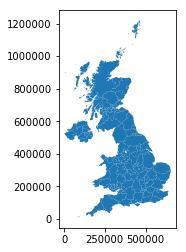

In [943]:
map_df.plot()

Yes.

OK, now we need to merge the price paid data into the map_df dataframe. We do this with a 'join' which, by default, uses the indexes of the two dataframes as the basis for the merger. In this case, we have used he area name as the index in both the map_df dataframe and the merge_df dataframe so things should just work.

When we look at the result, note that some of the mean prices paid can be NaNs - this is because we still have Scotland and Northern Ireland in the map data but we don't have any price paid data for those areas.

In [944]:
# join the map_df with the cleaned up merge_df dataframe
map_df = map_df.join(merge_df)
map_df.head()

,geometry,mean_price
ctyua19nm,,
Aberdeen City,"MULTIPOLYGON (((385726.999 815937.800, 385745....",NaN
Aberdeenshire,"MULTIPOLYGON (((352897.520 868195.600, 352902....",NaN
Angus,"POLYGON ((346942.001 788024.500, 347121.001 78...",NaN
Antrim and Newtownabbey,"POLYGON ((132534.120 554148.854, 132547.852 55...",NaN
Ards and North Down,"MULTIPOLYGON (((158867.138 537823.357, 158868....",NaN


Finally, let's plot the map. We use 'matplotlib' to control the plot, adding a heading, some annotation and a legend to show what the different colours indicate.

Note that we create a second plot so that any areas where the mean_price is NaN, we show it as grey so that it isn't confused as real data.

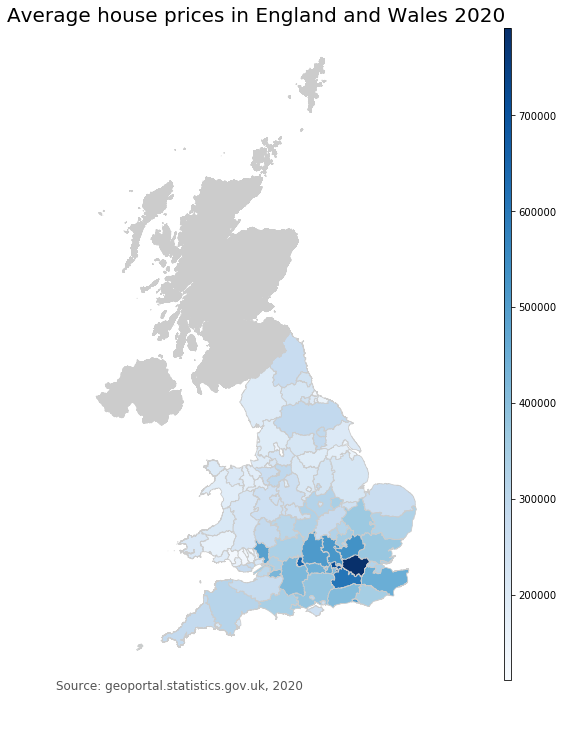

In [947]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Set the range for the choropleth
vmin, vmax = map_df.mean_price.min(), map_df.mean_price.max()
#vmin, vmax = 0, 1000000
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 12))
ax.set_aspect('equal')
# Remove the axis
ax.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=1)
# Create map
map_df.plot(column='mean_price',
            cmap='Blues',
            legend=True,
            linewidth=0.8,
            ax=ax,
            cax=cax,
            edgecolor='0.8',
            vmin=vmin, vmax=vmax
           )
# Add a title
ax.set_title('Average house prices in England and Wales 2020',
             fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create an annotation for the data source
ax.annotate('Source: geoportal.statistics.gov.uk, 2020', xy=(0.1, .08),
            xycoords='figure fraction', horizontalalignment='left',
            verticalalignment='top', fontsize=12, color='#555555')
# For any areas where the mean_price is Nan, replot them in grey to show that data is missing.
map_df[map_df.mean_price.isnull()].plot(ax=ax, color='0.8', edgecolor='0.8')
plt.show()

In [946]:
# Used during testing to show any areas where the mean_price is NaN - this
# helped to find sub areas that needed merging into the latger areas in the
# process above.
#df1 = map_df[map_df.isna().any(axis=1)]
#np.set_printoptions(threshold=2000)
#print(df1)

All done.